do onehot location

change train and test files

how to evaluate Interval prediction?

aval model ha Gridsearch bezan

# Setup

In [ ]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

## Defining functions

In [ ]:
def evaluation(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [ ]:
def load_data():
    url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'

    response = requests.get(url)

    with open('m1.parquet', 'wb') as f:
        f.write(response.content)


    url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet'

    response = requests.get(url)

    with open('m2.parquet', 'wb') as f:
        f.write(response.content)




    data1 = pd.read_parquet('m1.parquet')
    data2 = pd.read_parquet('m2.parquet')
    return data1, data2

In [ ]:
def date_format_modifier(data):# Year/Month/Day

    data['tpep_pickup_datetime'] = pd.DataFrame([int(date.strftime("%d")) for date in data['tpep_pickup_datetime']])
    data = data.dropna()

    return data

In [ ]:
def grouping_by(data, group_list):
    data_grouped = data.groupby(group_list, as_index = False)['extra'].count()
    data_grouped = data_grouped.rename(columns={'extra' : 'Demand'})
    data_grouped.index = data_grouped['tpep_pickup_datetime']

    return data_grouped

In [ ]:
def clearing_data_noise(data, month):
    clean_data = data[[int(date.strftime("%m")) == month for date in data['tpep_pickup_datetime']]]
    clean_data = clean_data.dropna()

    return clean_data

In [ ]:
def lower_upper_bound_predict(model, model_numbers, sample_size, train_data, test_data):

    num_samples = train_data.shape[0]
    indices = np.arange(num_samples)  # Create an array of indices

    bagging_test_predictions = []
    bagging_train_predictions = []
    for i in range(model_numbers):

      resampled_indices  = np.random.choice(indices, size = int(sample_size * num_samples), replace = True) #cant resample from n-d array so we are sampling indices
      resampled_data = train_data[resampled_indices]

      model.fit(resampled_data[:, :2], resampled_data[:, 2:].reshape(-1,))

      test_predictions = model.predict(test_data[:, :2])
      train_predictions = model.predict(train_data[:, :2])

      bagging_test_predictions.append(test_predictions)
      bagging_train_predictions.append(train_predictions)

    bagging_test_predictions = np.array(bagging_test_predictions)
    bagging_train_predictions = np.array(bagging_train_predictions)

    test_lower_bound = np.percentile(bagging_test_predictions, 5, axis=0)
    test_upper_bound = np.percentile(bagging_test_predictions, 95, axis=0)

    train_lower_bound = np.percentile(bagging_train_predictions, 5, axis=0)
    train_upper_bound = np.percentile(bagging_train_predictions, 95, axis=0)

    return (train_lower_bound, train_upper_bound), (test_lower_bound, test_upper_bound)

In [165]:
def bound_visualizer(train_data, test_data, train_bounds, test_bounds, end_day):
    plot_length = len(train_data['Demand'][1: end_day])
    plt.title('Train')
    plt.plot(train_data['Demand'][1: end_day])
    plt.plot(np.linspace(1, end_day, plot_length), train_bounds[0][:plot_length].reshape(-1,))
    plt.plot(np.linspace(1, end_day, plot_length), train_bounds[1][:plot_length].reshape(-1,))
    plt.show()

    plot_length = len(test_data['Demand'][1: end_day])
    plt.title('Test')
    plt.plot(test_data['Demand'][1: end_day])
    plt.plot(np.linspace(1, end_day, plot_length), test_bounds[0][:plot_length].reshape(-1,))
    plt.plot(np.linspace(1, end_day, plot_length), test_bounds[1][:plot_length].reshape(-1,))
    plt.show()

In [ ]:
def grid_search(model, parameters, train_data, cv):
    gs = GridSearchCV(model, parameters, cv=cv)
    gs.fit(train_data[:, :2], train_data[:, 2:].reshape(-1,))
    return gs.best_params_

In [173]:
def point_predict(model, train_data, test_data):
    model.fit(train_data[:, :2], train_data[:, 2:].reshape(-1,))


    yhat_train = model.predict(train_data[:, :2])
    yhat_test = model.predict(test_data[:, :2])

    return yhat_train, yhat_test

In [166]:
def point_predict_visualizer(train_data, test_data, yhat_train, yhat_test, end_day):

    plot_length = len(train_data['Demand'][1: end_day])
    plt.title('Train')
    plt.plot(train_data['Demand'][1: end_day])
    plt.plot(np.linspace(1, end_day, plot_length), yhat_train[:plot_length].reshape(-1,))
    plt.show()

    plot_length = len(test_data['Demand'][1: end_day])
    plt.title('Test')
    plt.plot(test_data['Demand'][1: end_day])
    plt.plot(np.linspace(1, end_day, plot_length), yhat_test[:plot_length].reshape(-1,))
    plt.show()

# Main

## initialization and loading dataset

In [ ]:
group_list = ['tpep_pickup_datetime', 'PULocationID']

data1, data2 = load_data()


In [ ]:
data1 = clearing_data_noise(data1, 1)
data2 = clearing_data_noise(data2, 2)

In [ ]:
data1_modified = date_format_modifier(data1)
data2_modified = date_format_modifier(data2)

In [ ]:
data1_grouped = grouping_by(data1, group_list)
data2_grouped = grouping_by(data2, group_list)

## Visualizing dataset

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(-5.0, 0, '−5'),
  Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25'),
  Text(30.0, 0, '30'),
  Text(35.0, 0, '35')])

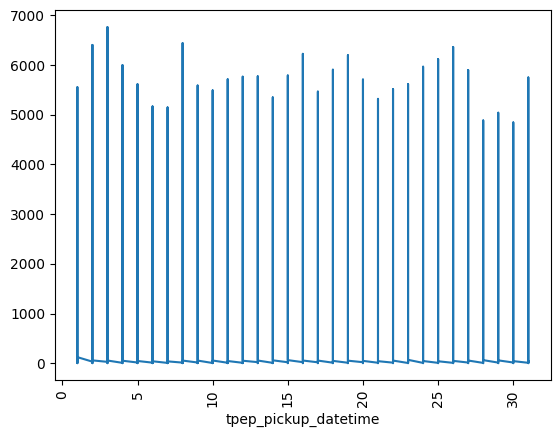

In [ ]:
data1_grouped['Demand'].plot()
plt.xticks(rotation=90)

## Training with first month and testing with second month

### initialization

In [ ]:
model_numbers = 20
sample_size = 0.6

### **Linear Regression**

#### Point based prediction

In [164]:
model = LinearRegression()
yhat_train, yhat_test = point_predict(model, data1_grouped.to_numpy(), data2_grouped.to_numpy())

##### Visualization

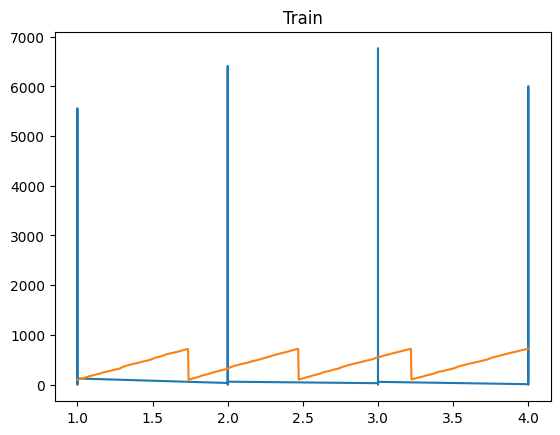

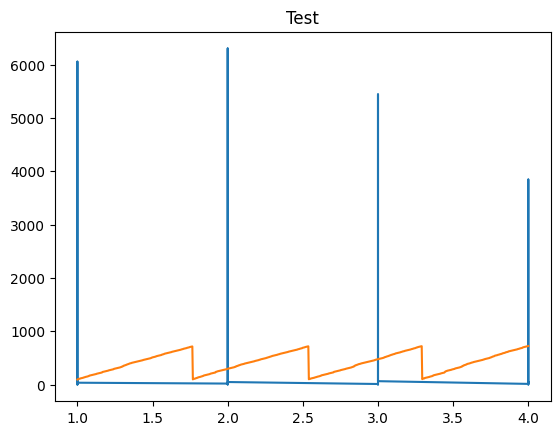

In [167]:
point_predict_visualizer(data1_grouped, data2_grouped, yhat_train, yhat_test, 4)

##### Evaluation

In [168]:
print('Linear regression train scores:')


evaluation(mean_absolute_error, 'MAE', data1_grouped['Demand'], yhat_train)
evaluation(mean_squared_error, 'MSE', data1_grouped['Demand'], yhat_train)

print('Linear regression test scores:')


evaluation(mean_absolute_error, 'MAE', data2_grouped['Demand'], yhat_test)
evaluation(mean_squared_error, 'MSE', data2_grouped['Demand'], yhat_test)


Linear regression train scores:
MAE : 641.52794517502
MSE : 974624.0003222945
Linear regression test scores:
MAE : 658.1476045547
MSE : 1037273.2548404518


#### Interval based prediction

In [169]:
model = LinearRegression()
train_bounds, test_bounds = lower_upper_bound_predict(model, model_numbers, sample_size, data1_grouped.to_numpy(), data2_grouped.to_numpy())

##### Visualization

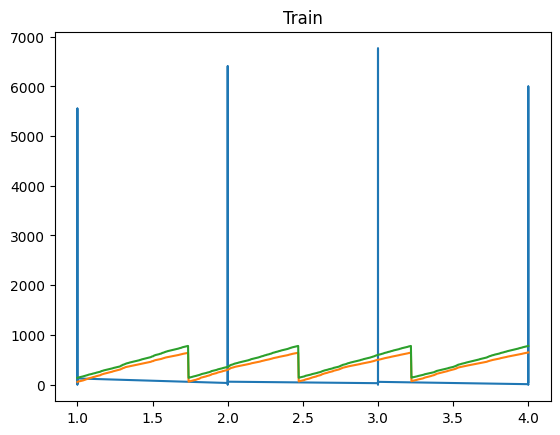

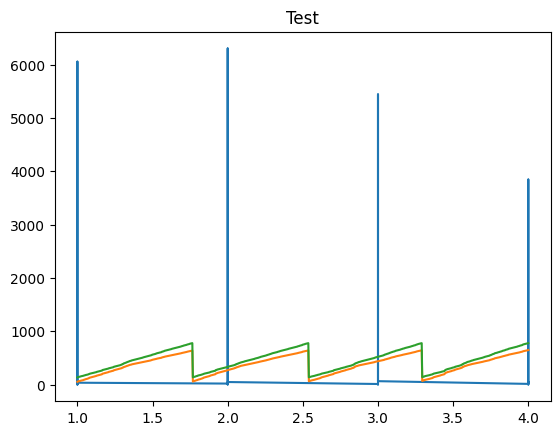

In [170]:
bound_visualizer(data1_grouped, data2_grouped, train_bounds, test_bounds, 4)

##### Evaluation

In [171]:
print('Linear regression train scores:')

train_predicted_point = (train_bounds[0] + train_bounds[1])/2
evaluation(mean_absolute_error, 'MAE', data1_grouped['Demand'], train_predicted_point)
evaluation(mean_squared_error, 'MSE', data1_grouped['Demand'], train_predicted_point)

print('Linear regression test scores:')

test_predicted_point = (test_bounds[0] + test_bounds[1])/2
evaluation(mean_absolute_error, 'MAE', data2_grouped['Demand'], test_predicted_point)
evaluation(mean_squared_error, 'MSE', data2_grouped['Demand'], test_predicted_point)


Linear regression train scores:
MAE : 640.0604957892716
MSE : 974735.3327600597
Linear regression test scores:
MAE : 656.8082492250936
MSE : 1037421.0271962594


### **Random Forest Regressor**

#### Point based prediction

##### Grid search to find best hyper parameters

In [186]:
model = RandomForestRegressor()
best_params = grid_search(model, {'n_estimators' : [1000], 'max_depth' : [4, 7, 10]}, data1_grouped.to_numpy(), cv = 5)

In [190]:
model = RandomForestRegressor(**best_params)
yhat_train, yhat_test = point_predict(model, data1_grouped.to_numpy(), data2_grouped.to_numpy())

##### Visualization

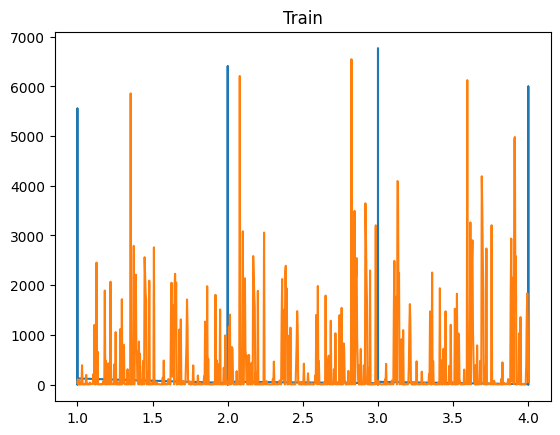

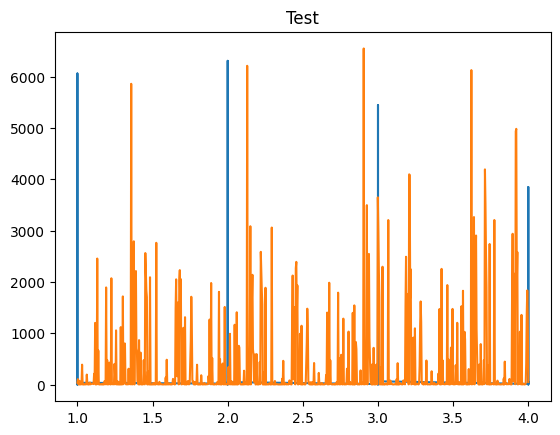

In [191]:
point_predict_visualizer(data1_grouped, data2_grouped, yhat_train, yhat_test, 4)

##### Evaluation

In [192]:
print('Random forest regression train scores:')


evaluation(mean_absolute_error, 'MAE', data1_grouped['Demand'], yhat_train)
evaluation(mean_squared_error, 'MSE', data1_grouped['Demand'], yhat_train)

print('Random forest regression test scores:')


evaluation(mean_absolute_error, 'MAE', data2_grouped['Demand'], yhat_test)
evaluation(mean_squared_error, 'MSE', data2_grouped['Demand'], yhat_test)


Random forest regression train scores:
MAE : 22.187260830728004
MSE : 4563.601779702994
Random forest regression test scores:
MAE : 134.13116181549086
MSE : 157086.37617115228


#### Interval based prediction

In [ ]:
model = RandomForestRegressor(max_depth = 4)
train_bounds, test_bounds = lower_upper_bound_predict(model, model_numbers, sample_size, data1_grouped.to_numpy(), data2_grouped.to_numpy())

##### Visualization

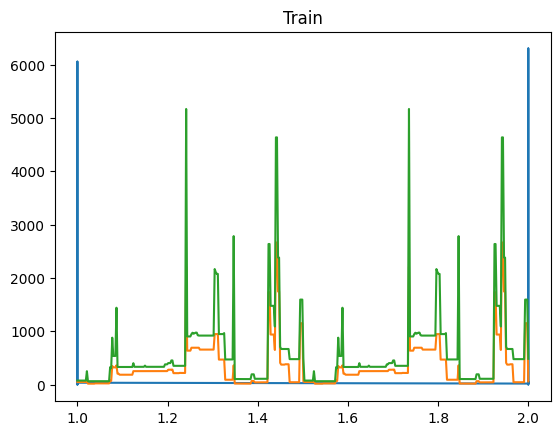

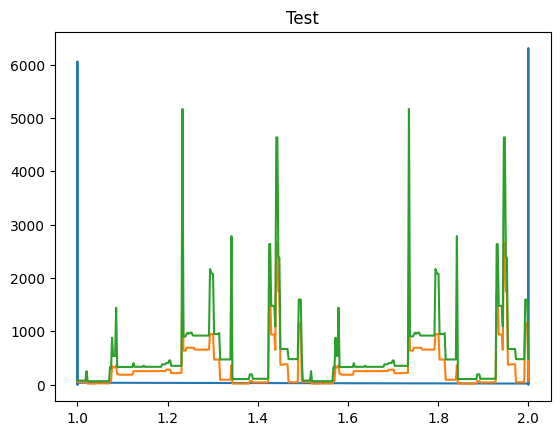

In [ ]:
bound_visualizer(data1_grouped, data2_grouped, train_bounds, test_bounds, 2)

##### Evaluation

In [ ]:
print('Random forest regression train scores:')

train_predicted_point = (train_bounds[0] + train_bounds[1])/2
evaluation(mean_absolute_error, 'MAE', data1_grouped['Demand'], train_predicted_point)
evaluation(mean_squared_error, 'MSE', data1_grouped['Demand'], train_predicted_point)

print('Random forest regression test scores:')

test_predicted_point = (test_bounds[0] + test_bounds[1])/2
evaluation(mean_absolute_error, 'MAE', data2_grouped['Demand'], test_predicted_point)
evaluation(mean_squared_error, 'MSE', data2_grouped['Demand'], test_predicted_point)


Random forest regression train scores:
MAE : 410.9820127762798
MSE : 465281.9479124962
Random forest regression test scores:
MAE : 430.52488413991574
MSE : 517915.882853342


### **SVM**

#### Point based prediction

##### Grid search to find best hyper parameters

In [ ]:
model = svm.SVR()
best_params = grid_search(model, {'C' : [0.1,100], 'gamma' :  [0.01, 100], 'kernel': ['rbf']}, data1_grouped.to_numpy(), cv = 5)

In [179]:
model = svm.SVR(**best_params)
yhat_train, yhat_test = point_predict(model, data1_grouped.to_numpy(), data2_grouped.to_numpy())

##### Visualization

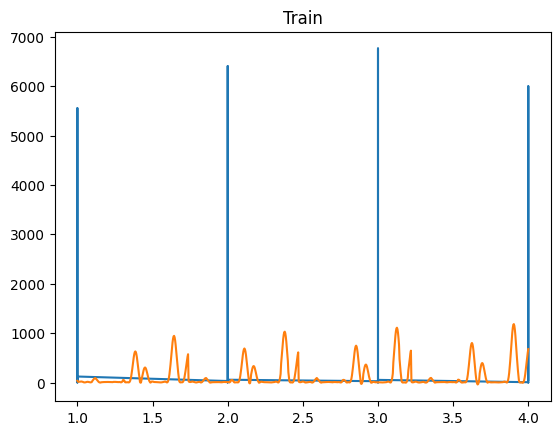

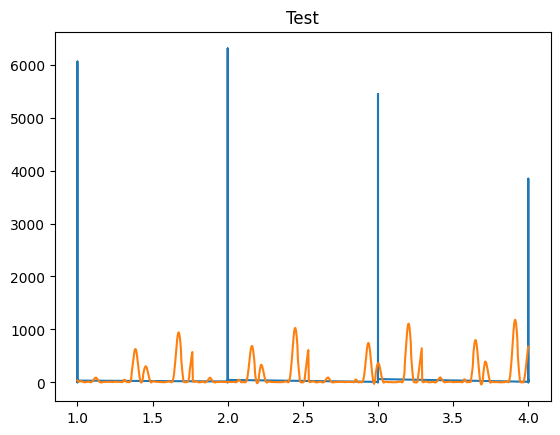

In [180]:
point_predict_visualizer(data1_grouped, data2_grouped, yhat_train, yhat_test, 4)

##### Evaluation

In [181]:
print('SVM regression train scores:')


evaluation(mean_absolute_error, 'MAE', data1_grouped['Demand'], yhat_train)
evaluation(mean_squared_error, 'MSE', data1_grouped['Demand'], yhat_train)

print('SVM regression test scores:')


evaluation(mean_absolute_error, 'MAE', data2_grouped['Demand'], yhat_test)
evaluation(mean_squared_error, 'MSE', data2_grouped['Demand'], yhat_test)


SVM regression train scores:
MAE : 400.75421488748896
MSE : 860910.0229252519
SVM regression test scores:
MAE : 420.3914272222187
MSE : 927352.4749601231


#### Interval based prediction

In [ ]:
model = svm.SVR(**best_params)
train_bounds, test_bounds = lower_upper_bound_predict(model, model_numbers, sample_size, data1_grouped.to_numpy(), data2_grouped.to_numpy())

##### Visualization

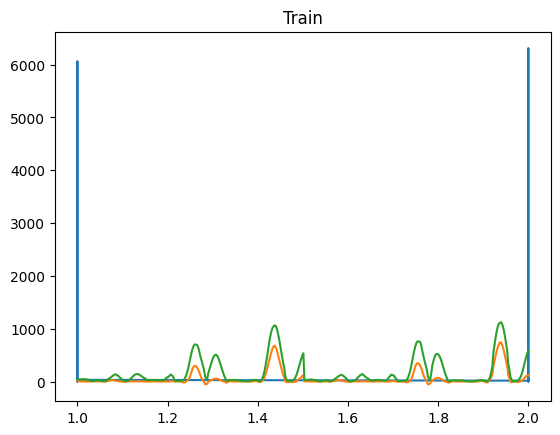

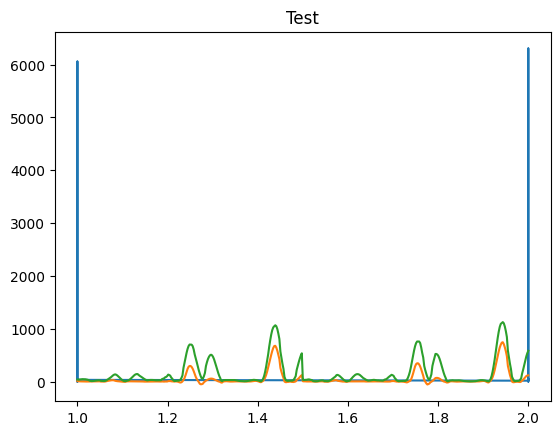

In [ ]:
bound_visualizer(data1_grouped, data2_grouped, train_bounds, test_bounds, 2)

##### Evaluation

In [ ]:
print('SVM regression train scores:')

train_predicted_point = (train_bounds[0] + train_bounds[1])/2
evaluation(mean_absolute_error, 'MAE', data1_grouped['Demand'], train_predicted_point)
evaluation(mean_squared_error, 'MSE', data1_grouped['Demand'], train_predicted_point)

print('SVM regression test scores:')

test_predicted_point = (test_bounds[0] + test_bounds[1])/2
evaluation(mean_absolute_error, 'MAE', data2_grouped['Demand'], test_predicted_point)
evaluation(mean_squared_error, 'MSE', data2_grouped['Demand'], test_predicted_point)


SVM regression train scores:
MAE : 408.0809833685458
MSE : 892179.6354854854
SVM regression test scores:
MAE : 427.66564260787237
MSE : 959759.4810770552


### **KNN**

#### Point based prediction

##### Grid search to find best hyper parameters

In [194]:
model = KNeighborsRegressor()
best_params = grid_search(model, {'n_neighbors' : list(range(2,100))}, data1_grouped.to_numpy(), cv = 5)

In [195]:
model = KNeighborsRegressor(**best_params)
yhat_train, yhat_test = point_predict(model, data1_grouped.to_numpy(), data2_grouped.to_numpy())

##### Visualization

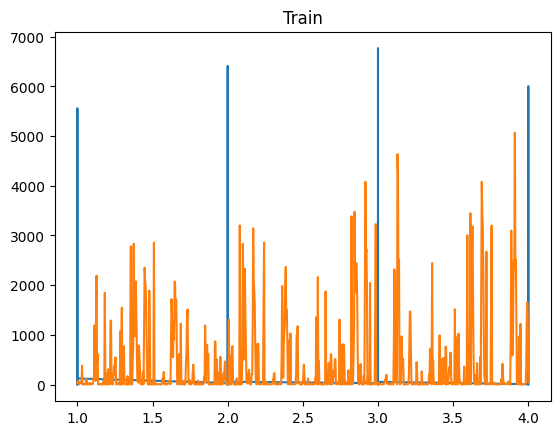

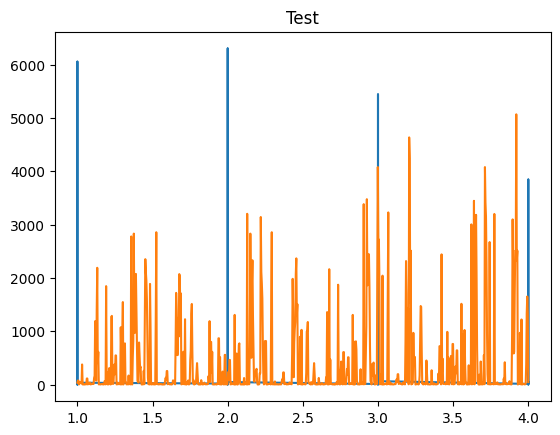

In [199]:
point_predict_visualizer(data1_grouped, data2_grouped, yhat_train, yhat_test, 4)

##### Evaluation

In [201]:
print('KNN regression train scores:')


evaluation(mean_absolute_error, 'MAE', data1_grouped['Demand'], yhat_train)
evaluation(mean_squared_error, 'MSE', data1_grouped['Demand'], yhat_train)

print('KNN regression test scores:')


evaluation(mean_absolute_error, 'MAE', data2_grouped['Demand'], yhat_test)
evaluation(mean_squared_error, 'MSE', data2_grouped['Demand'], yhat_test)


KNN regression train scores:
MAE : 151.31144856334674
MSE : 163465.52895637933
KNN regression test scores:
MAE : 225.4541193882585
MSE : 299809.7550156224


#### Interval based prediction

In [202]:
model = KNeighborsRegressor(**best_params)
train_bounds, test_bounds = lower_upper_bound_predict(model, model_numbers, sample_size, data1_grouped.to_numpy(), data2_grouped.to_numpy())

##### Visualization

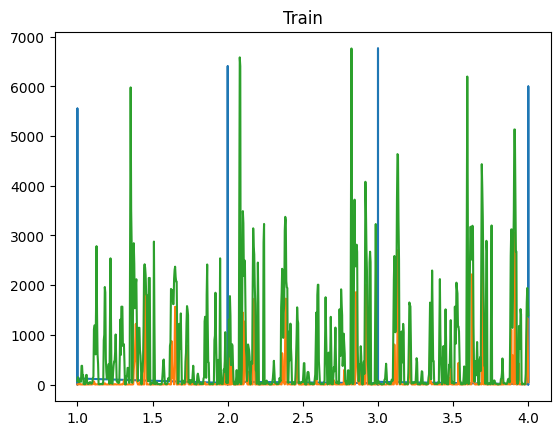

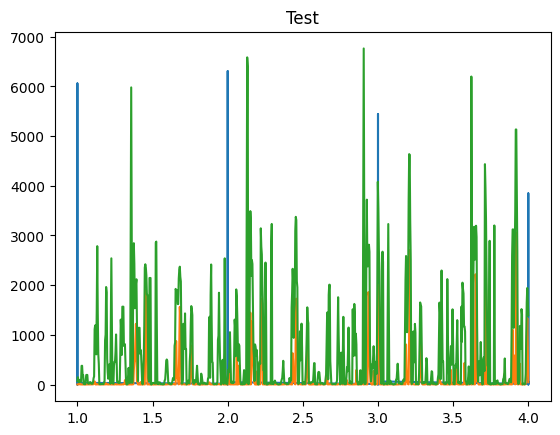

In [203]:
bound_visualizer(data1_grouped, data2_grouped, train_bounds, test_bounds, 4)

##### Evaluation

In [204]:
print('KNN regression train scores:')

train_predicted_point = (train_bounds[0] + train_bounds[1])/2
evaluation(mean_absolute_error, 'MAE', data1_grouped['Demand'], train_predicted_point)
evaluation(mean_squared_error, 'MSE', data1_grouped['Demand'], train_predicted_point)

print('KNN regression test scores:')

test_predicted_point = (test_bounds[0] + test_bounds[1])/2
evaluation(mean_absolute_error, 'MAE', data2_grouped['Demand'], test_predicted_point)
evaluation(mean_squared_error, 'MSE', data2_grouped['Demand'], test_predicted_point)


KNN regression train scores:
MAE : 284.4836980794998
MSE : 296182.97787037556
KNN regression test scores:
MAE : 333.09194828153267
MSE : 418777.2776777823
